In [158]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [159]:
# Read the df_zoho_form_cleaned and store in a variable
df_zoho_form_analysis = pd.read_csv('C:\\Language_Projects\\Language_Projects\\Python\\Flagship_1\\automotive_diagnostic_data_analysis\\data\\df_zoho_google_cleaned.csv')

In [160]:
# Print the info
df_zoho_form_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5352 entries, 0 to 5351
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_time                   5352 non-null   object 
 1   h_number                       5352 non-null   object 
 2   entry_type                     5352 non-null   object 
 3   technician                     5337 non-null   object 
 4   source                         5352 non-null   object 
 5   year                           5352 non-null   float64
 6   make                           5352 non-null   object 
 7   model                          5351 non-null   object 
 8   engine_size                    5204 non-null   object 
 9   hdw_number                     4738 non-null   object 
 10  part_number                    5085 non-null   object 
 11  notes                          5352 non-null   object 
 12  original_problems              5347 non-null   o

In [161]:
# Define the regex pattern to find the dtcs
dtcs_pattern = r'[PBCUpbcu]\d{3}[0-9A-Za-z]'

# List to store the dtcs found
fs1_dtcs_list = []

# Iterate under the column 'fs1-dtcs' to find the dtcs
for item in df_zoho_form_analysis['fs1_dtcs']:
    # Check if the data found is a string
    if isinstance(item, str):
        # Find all dtcs using the regex pattern
        fs1_dtcs_found = re.findall(dtcs_pattern, item, re.IGNORECASE)
        fs1_dtcs_list.extend(fs1_dtcs_found)

In [162]:
# Count the frequency of the dtcs
dtcs_counts = pd.Series(fs1_dtcs_list).value_counts()

In [163]:
# Create a dataframe from the result and name the columns
dtcs_quantity = pd.DataFrame({'DTCs': dtcs_counts.index, 'Quantity': dtcs_counts.values})

In [164]:
# Variable to save the top 15 dtcs as the DTC P0315 is not relevante or causes any problems.
top_dtcs = dtcs_quantity.head(16)

In [165]:
# Print the top 16 dtcs
top_dtcs

,DTCs,Quantity
0,P0315,310
1,P0633,205
2,U0100,118
3,P0513,101
4,P0300,95
5,P0700,71
6,P1631,70
7,P2122,65
8,P2127,64
9,P160A,63


In [169]:
# Create a list from column 'DTCs'
top_dtcs_list = top_dtcs['DTCs'].tolist()

In [170]:
# Filter the main df containing the top 10 dtcs
df_filtered_top_ten_dtcs = df_zoho_form_analysis[df_zoho_form_analysis['fs1_dtcs'].str.contains('|'.join(top_dtcs_list), na=False, case=False)]

After filtering the data using the top 15 dtcs as the criterias, the following analysis will be done related to the prescreen notes:
- Analyse the resolutions given / DTC to confirm if they are correct.
- Performance of the tech (counting the quantity of accounts prescreened).
- When no codes provided, check the quality of the symptoms descriptions (CHARS QUANTITY) used to state the symptoms outside the                            'most_common_used_symptoms_list' / tech. If the tech is describing the symptoms clearly.
- The most common symptoms described by the customer and suggest including them on the zoho form
- When selecting "Return unit to testing department" and "Return unit for replacement", is there a reason? / Tech. Check the additional notes and the chacteres quantity on it. This may indicate the tech gave the reason.
- When selected the problems are the same as the original ones, what is usually the resolution? If "Return unit to testing department" and "Return unit for replacement", what was the reason for such option / Tech. This indicates how much the tech is diagnosing the problems.
- Which is the most common symptoms as described on the 'most_common_used_symptoms_list'.
- The most common hdws storing the most common dtcs (top 20 dtcs).

FUCTIONS

In [ ]:
# Function to create a dataframe with with the dtcs stored by the Flagship One ECM
def create_df_top_dtcs_fs1_ecu_stored(dtc, df_filtered_top_dtcs):
    # Create a df with the entered DTC
    df_dtc_ = df_filtered_top_dtcs[df_filtered_top_dtcs['fs1_dtcs'].str.contains(dtc, na=False, case=False)]
    return df_dtc_

In [89]:
# Function to categorize the resolution texts
def categorize_resolutions(resolution_text, dict_categorize_reso_dtc):
    # Iterate under each category and their key-words
    for category, words in dict_categorize_reso_dtc.items():
        # Verify if any key-word is present in the text
        if any(word in resolution_text for word in words):
            # Return the category
            return category
    # If no key-word is find, return 'OTHERS'
    return 'OTHERS'

In [130]:
# Function to create a dictionary with dataframes showing the frequency of resolutions/make based on the dtc 
def resolution_report(df_dtc, make_quantity_dtc):
    # Create dict to store the dfs
    dict_with_resolution_dfs = {}
    # Iterate into the df containing how many times a dtc was stored / make
    for make in make_quantity_dtc['Make']:
        # Filter the main df considering the make
        df_dtc_make = df_dtc[df_dtc['make'] == make]
        # Count how many times a resolution was given
        resolutions_quantity = df_dtc_make['resolution'].value_counts()
        # Create a df with resolution/quantity
        df_resolutions_quantity = pd.DataFrame({'Resolutions': resolutions_quantity.index, 'Quantity': resolutions_quantity.values})
        # Store the df into a dictionary
        dict_with_resolution_dfs[make] = df_resolutions_quantity
    return dict_with_resolution_dfs

In [131]:
# Function to pass the makes with lowest numbers of resolutions and create the chart
def pass_makes_print_chart(dict_reso_dtc, low_resolution_quantity_dtc_list):
    # Loop to create the makes which stored the code P0633
    for make, df in dict_reso_dtc.items():
        # Condition to create the chart without the makes with low number of resolutions.
        if make not in [low_resolution_quantity_dtc_list]:
            # Set up the chart size
            plt.figure(figsize=(8, 4))
            # Axis Y must come first because the quantity is at the X axis and store under a variable the set up of the Y and X axis
            reso_bar_p0633 = plt.barh(df['Categ. Resolution'], df['Quantity'], color='darkblue')
            # Name the X label
            plt.xlabel('Quantity')
            # Name the Y label
            plt.ylabel('Resolution')
            # Name the title
            plt.title(f'{make} - Resolution for DTC P0633')
            plt.tight_layout()
            # Label the bars
            plt.bar_label(reso_bar_p0633)
            # Show the chart
    return  plt.show()

In [143]:
# Function to count the top 10 resolutions
def count_top_ten_resolutions(df_dtc_):
    # Create a series containing the resolutions, count the values and store the top 10 resolutions under a variable
    top_ten_resolutions_dtc = df_dtc_['resolution'].value_counts().head(10)
    # Return the variable
    return top_ten_resolutions_dtc

RESOLUTION ANALYSES - DTC P0633

In [171]:
# Print the most common dtcs list
top_dtcs

,DTCs,Quantity
0,P0315,310
1,P0633,205
2,U0100,118
3,P0513,101
4,P0300,95
5,P0700,71
6,P1631,70
7,P2122,65
8,P2127,64
9,P160A,63


In [ ]:
# Call the function to create a df only with rows 
df_dtc_p0633 = create_df_top_dtcs_fs1_ecu_stored("P0633", df_filtered_top_ten_dtcs)

In [ ]:
# Call the function to create a df only with rows containing DTC P0633 stored by the FS1 ECU
top_ten_resolutions_p0633 = count_top_ten_resolutions(df_dtc_p0633)

In [175]:
# Print the result
top_ten_resolutions_p0633

resolution
Return both the original unit and our unit for cloning. If customer cannot return the original recommend replacing with another unit with matching PN                78
Return unit for replacement                                                                                                                                          47
Return unit to testing department                                                                                                                                    18
Need more information from the customer                                                                                                                              12
Customer must perform additional diagnosticsecurity steps                                                                                                            12
Return unit for SKIMLSA ResetRemoval and verify that it has been disabled.                                                                           

In [91]:
# Create a dict to categorize resolutions based on key words
dict_categorize_reso_p0633 = {
    'CLONING': ['Return both the original unit and our unit for cloning. If customer cannot return the original recommend replacing with another unit with matching PN'], 
    'REPLACEMENT': ['Return unit for replacement'],
    'TESTING': ['Return unit to testing department', 'Return unit for replacement and send it to cores'],
    'ADDITIONAL STEPS':['Customer must perform additional diagnosticsecurity steps'],
    'MORE INFO NEEDED': ['Need more information from the customer'],
    'SKIM/LSA RESET': ['Return unit for SKIMLSA ResetRemoval and verify that it has been disabled.'],
    'NOT PCM-RELATED': ['Problem not related to PCM'],
    'EXPLAINED ABOVE': ['Resolution explained above'],
    'NEW FORM NEEDED': ['we require the customer to READ CAREFULLY EACH SECTION and fill out a new form ANSWERING ALL questions properly.']
    }

In [92]:
# Call the function and store the result in a variable
dict_resolution_p0633 = resolution_report(df_dtc_p0633, make_quantity_p0633)

In [93]:
# Iterate over the dict containing {make: df([resolutions], [quantities])
for make, df in dict_resolution_p0633.items():
    # Iterate over the df and the column resolution
    for resolution in df['Resolutions']:
        # Add a column to all dataframes inside the dict to categorize the resolutions
        df["Categ. Resolution"] = df['Resolutions'].apply(categorize_resolutions, args=(dict_categorize_reso_p0633,))

In [94]:
# Print make/quantity df
make_quantity_p0633

,Make,Quantity
0,Chevrolet,121
1,GMC,31
2,Dodge,21
3,Buick,14
4,Cadillac,14
5,Jeep,8
6,Chrysler,2
7,Pontiac,1


As the makes Chrysler and Pontiac reprents a very low number, the charts will be created without those 2 makes. 

In [139]:
low_resolution_quantity_p0633_list = ['Chrysler', 'Pontiac']

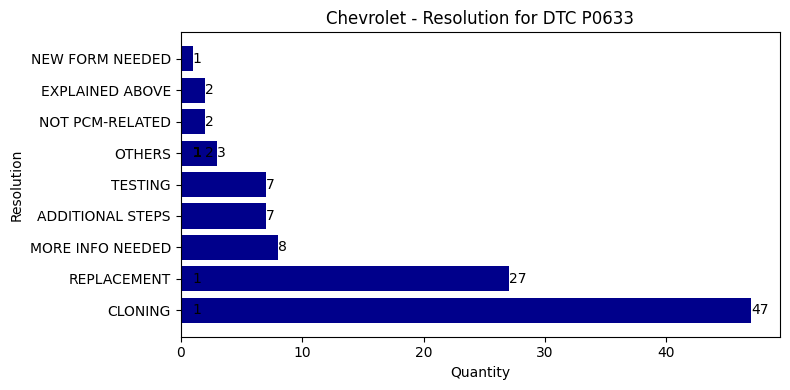

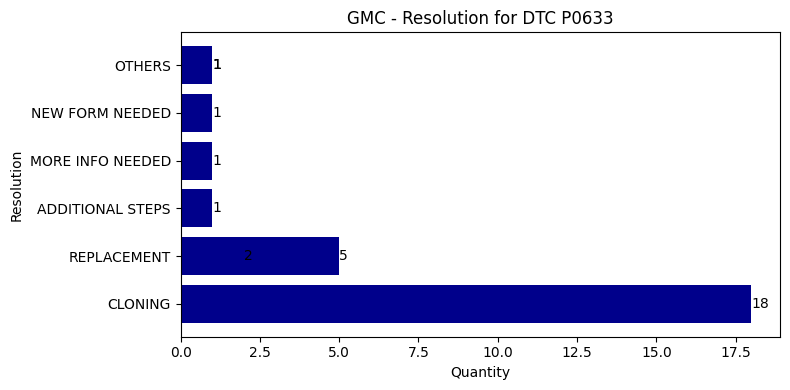

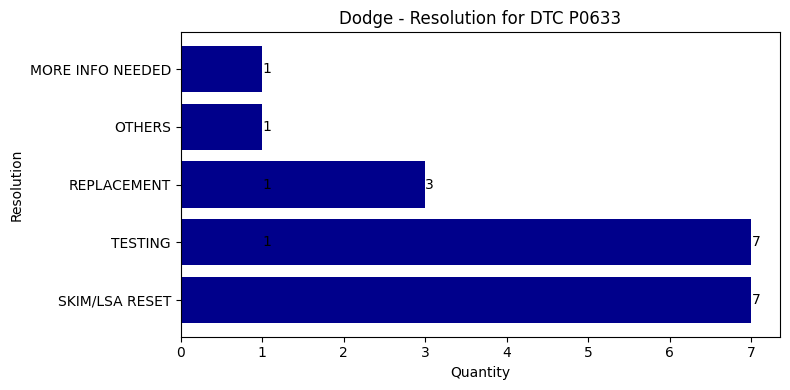

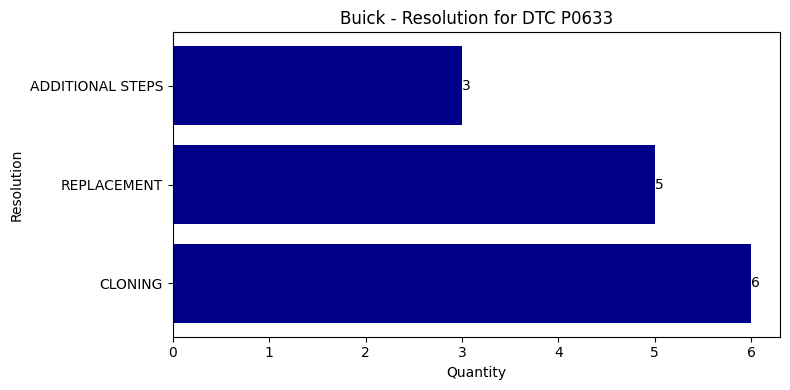

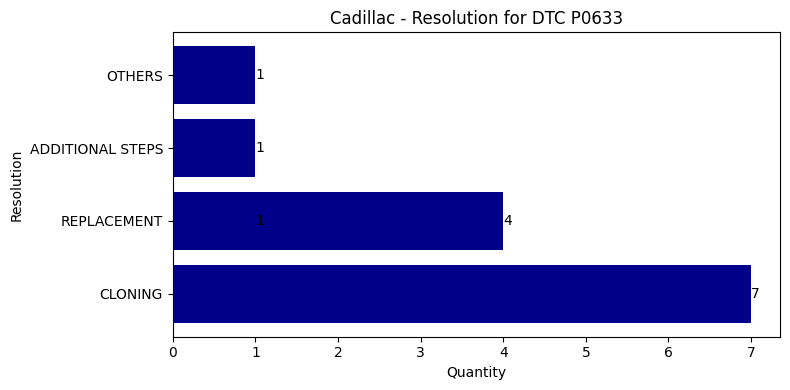

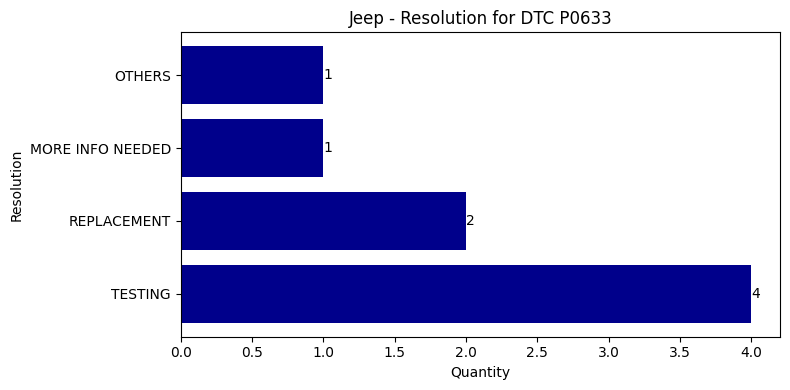

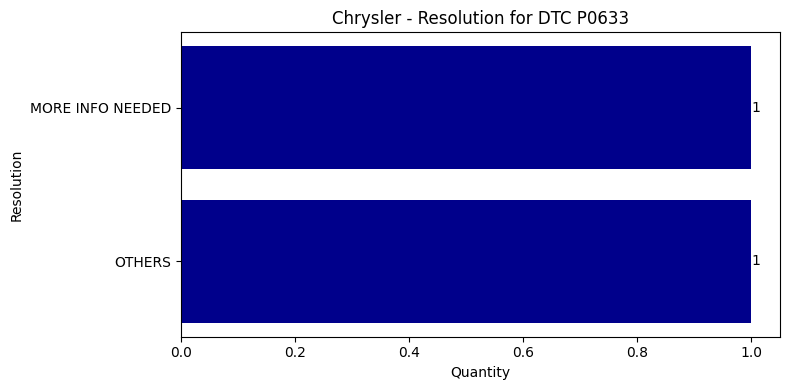

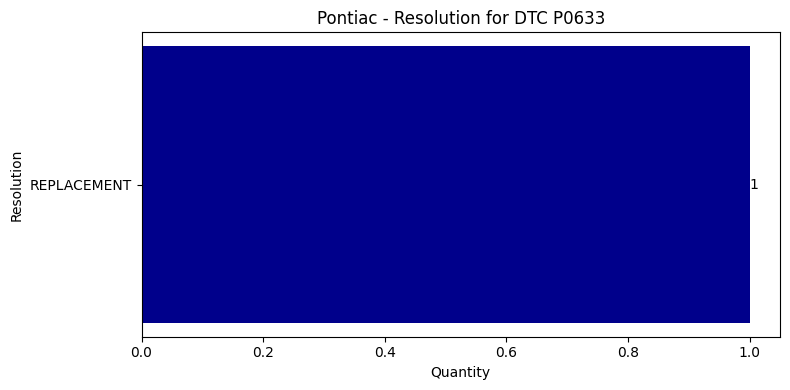

In [140]:
pass_makes_print_chart(dict_resolution_p0633, low_resolution_quantity_p0633_list)

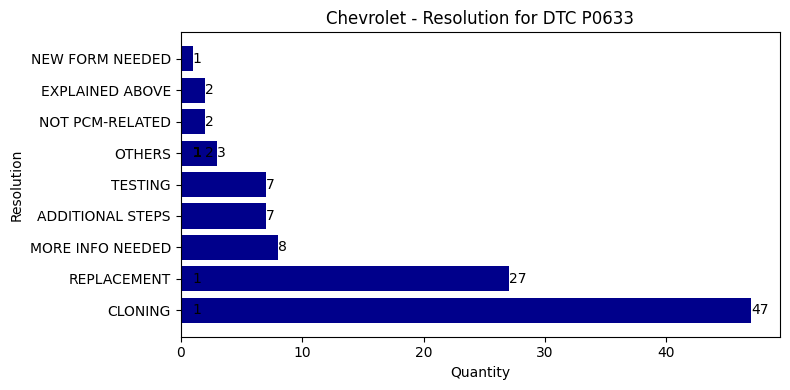

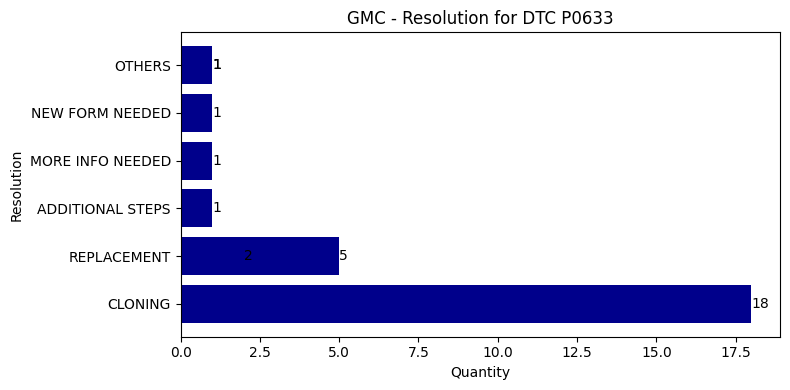

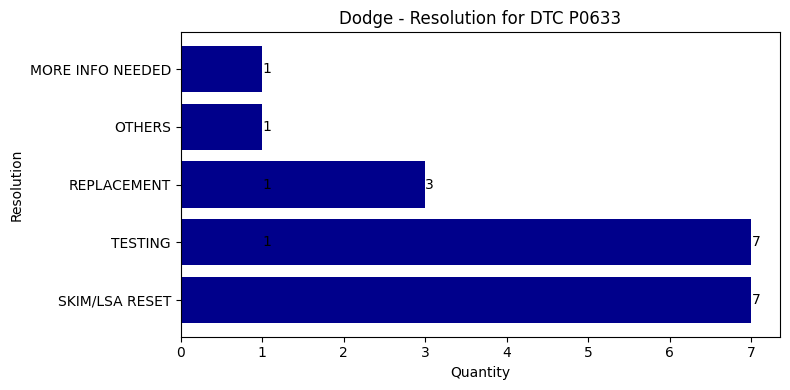

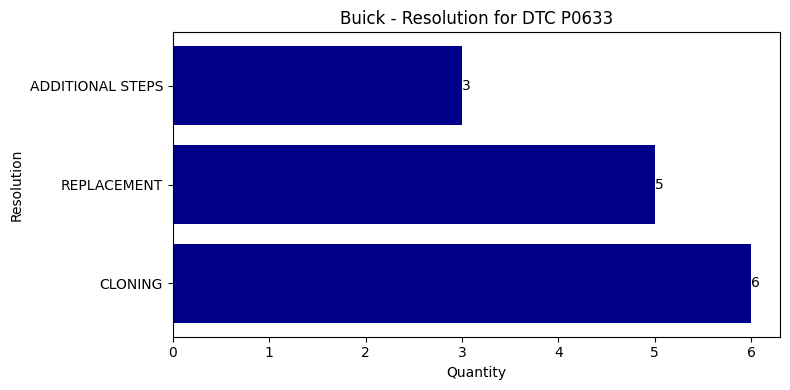

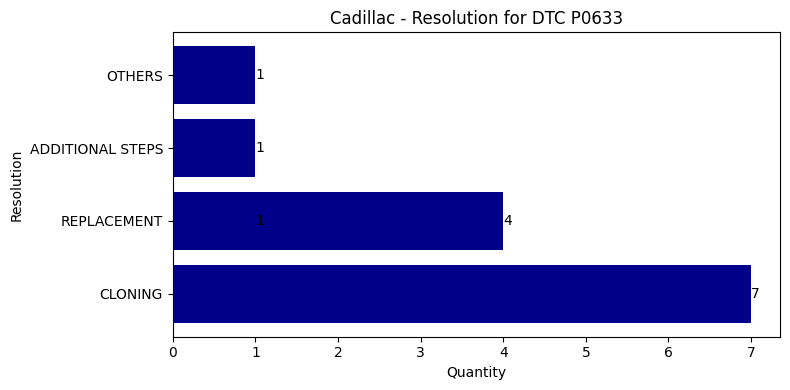

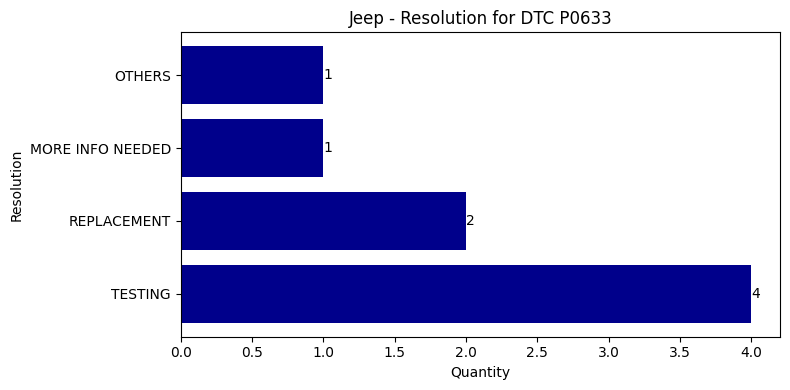

In [ ]:
# Loop to create the makes which stored the code P0633
for make, df in dict_resolution_p0633.items():
    # Condition to create the chart without the makes with low number of resolutions
    if make not in ['Chrysler', 'Pontiac']:
        # Set up the chart size
        plt.figure(figsize=(8, 4))
        # Axis Y must come first because the quantity is at the X axis and store under a variable the set up of the Y and X axis
        reso_bar_p0633 = plt.barh(df['Categ. Resolution'], df['Quantity'], color='darkblue')
        # Name the X label
        plt.xlabel('Quantity')
        # Name the Y label
        plt.ylabel('Resolution')
        # Name the title
        plt.title(f'{make} - Resolution for DTC P0633')
        plt.tight_layout()
        # Label the bars
        plt.bar_label(reso_bar_p0633)
        # Show the chart
        plt.show()

In [28]:
# Print the columns from the main df
df_zoho_form_analysis.columns

Index(['Unnamed: 0', 'Created Time', 'H Number', 'Entry Type', 'Technician',
       'Source', 'Year', 'Make', 'Model', 'Engine Size', 'HW #', 'Part #',
       'Notes', 'original_problem_zoho_form', 'original_dtcs',
       'fs1_problems_zoho_form', 'fs1_dtcs', 'original_fs1_problems_related',
       'additional_notes_zoho_form', 'resolution_zoho_form'],
      dtype='object')

In [29]:
# Drop the column 'Unnamed: 0'
df_zoho_form_dropped_column = df_zoho_form_analysis.drop(columns=['Unnamed: 0'])

CHECK HOW MUCH IS CLEAR THE SYMPTOMS FIELDS:


In [32]:
df_zoho_form_analysis['Technician'].value_counts()

Technician
Weverson      1372
Adeosun       1294
Tavasika C    1180
Martin        1014
Craig.G        116
Chris.R         68
Name: count, dtype: int64

In [ ]:
# Code to analyse the diagnostic is correct and the correct resolution was give.
# This is an example, as the code U0100 is common and can be stored by both modules, the following should be analysed:
# - When the tech selected 'Return unit to testing department' and 'Return unit for replacement': 
#      - If the code U0100 was stored originally AS WELL
#      - If the tech selected "Yes" in the problems related options
#      - If the tech explained why he decided to return the unit for testing OR 
#        replacement and what should be tested OR why he suggested a replacement

top_ten_resolutions_U0100 = count_top_ten_resolutions(df_dtc_u0100)

dict_top_ten_resolutions_U0100 = top_ten_resolutions_U0100.to_dict()


# Iterate under the dict and eliminate the low resolution quantity and store in this list
top_ten_resolutions_U0100_list = []


for reso, qt in dict_top_ten_resolutions_U0100.items():
    if qt not in [3, 2, 1]:
        top_ten_resolutions_U0100_list.append({
            'Resolution': reso,
            'Quantity': qt
        })    

df_dtc_u0100_testing = df_dtc_u0100[df_dtc_u0100['resolution'].str.contains('Return unit to testing department', na=False, case=False)]

df_dtc_u0100_testing['additional_notes'][3757]


# REGARDING THE MOST COMMON SYMPTOMS
# List with the most common symptoms used by the techs
most_common_used_symptoms_list = ['randomly no start', 'runs roughly', 'run rough', 'idling rough', 'idle rough', 'no start', 'not shifting', 'misfiring', 
                                'no communication', 'shut off', 'shutting off', 'stalling', 'no crank no start', 'crank no start', 
                                'starts and shuts off', 'starts and stalls', 'starts and shuts off after 3 sec', 'transmission issues', 'shifting issues',
                                'no communication with scanner', 'no communication with the scanner', 'no throttle response', 'no acceleration']

# Create a list with the size of the most common symptoms.
symptoms_char_counts = []

for symptom in most_common_used_symptoms_list:
    char_count = len(symptom)
    symptoms_char_counts.append({
        'Symptom': symptom,
        'Character Count': char_count
        })
    
pd.DataFrame(symptoms_char_counts)

dict_form_check_box = {
                        'Sensors': ['Accelerator Pedal Position Sensor', 'Barometric Pressure Sensor', 'Battery Temperature Sensor', 'Camshaft Position Sensor',
                        'Crankshaft Position Sensor', 'Cylinder Head Temperature Sensor', 'Engine Coolant Temperature Sensor', 'Exhaust Back Pressure Sensor',
                        'Fuel Rail Pressure Sensor', 'Fuel Tank Pressure Sensor', 'Intake Air Temperature Sensor', 'Manifold Absolute Pressure Sensor', 
                        'Mass Air Flow Sensor', 'O2 Sensors', 'Oil Temperature Sensor','Speed Sensors', 'Throttle Position Sensor', 'Transmission Range Sensor', 'Water In Fuel Sensor',
                        'Brake Pedal Position Switch', 'Park/Neutral Safety Switch'],
                        'Actuators': ['Canister Vent Control', 'Cooling Fans', 'Evaporative Emissions System', 'Exhaust Gas Recirculation System', 'Fuel Injection Pressure Regulator',
                        'Idle Air Control System', 'Intake Manifold Runner', 'Throttle Actuator Control System', 'Wastegate Control System', 'Fuel Control Actuator'],
                        'Power Supply': ['Charging System', 'Power/Ground Inputs', 'Power/Ground Outputs'],             
                        'Trasmission': ['Overdrive System', 'Shift Solenoids', 'Torque Converter Clutch Control', 'Relays (ASD, Starter, Fuel Pump, Etc. Specify in notes.)'],
                        'Ignition System': ['Fuel Injectors', 'Glow Plug Control', 'Ignition Coils'],
                        'Others': ['Air Conditioning System' 'Communication Networks (CAN, CCD, Etc. Specify in notes.)', 'Cruise Control System', 'Immobilizer/Security', 
                        'Misfiring (Specific cause unknown)', 'Programming', 'Tow/Haul System']

                        }